In [1]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.metrics import MeanSquaredError
import matplotlib.pyplot as plt



In [2]:
df = yf.download("BTC-USD", start = "1900-01-01")
df.reset_index(inplace = True)
df.drop(columns = "Adj Close", inplace = True)
column_mapping = {'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}
df.rename(columns=column_mapping, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Date,open,high,low,close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
3466,2024-03-14,73079.375000,73750.070312,68563.023438,71396.593750,59594605698
3467,2024-03-15,71387.875000,72357.132812,65630.695312,69403.773438,78320453976
3468,2024-03-16,69392.484375,70046.273438,64801.394531,65315.117188,46842198371
3469,2024-03-17,65316.343750,68845.718750,64545.316406,68390.625000,44716864318


In [4]:
#Calculate Relative Strength Index
df["rsi"] = ta.rsi(df.close)

#Calculate Simple Moving Average (Short-Term)
df["sma"] = ta.sma(df.close, length=15)

#Calculate Bollinger Bands
b = ta.bbands(df.close, length=20)
df = df.join(b)

#Calculate MACD
a = ta.macd(df.close)
df = df.join(a)

#Calculate Exponential Moving Average (Short-Term)
df["ema"] = ta.ema(df.close, length=14)

#Calculate Directional Move Index
a = ta.dm(df.high, df.low, length=16)
df = df.join(a)

In [5]:
df.head()

,Date,open,high,low,close,volume,rsi,sma,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ema,DMP_16,DMN_16
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Calculate all candlesticks and create a dataframe called 'candles'
candles = df.ta.cdl_pattern(name="all")

#Evaluate the candlesticks
#pd.reset_option('display.max_columns')
#pd.set_option('display.max_columns', None)
#for column in candles.columns:
    # print(f"Column: {column}")
    # print(candles[column].value_counts())
    # print("\n")


#After evaluating all the candlesticks, all of the following were irrelevant (not enough signals). Drop them.
candles.drop(columns={"CDL_2CROWS","CDL_3STARSINSOUTH",
                  "CDL_ABANDONEDBABY","CDL_BREAKAWAY","CDL_CONCEALBABYSWALL",
                  "CDL_COUNTERATTACK","CDL_HIKKAKE","CDL_HIKKAKEMOD","CDL_INNECK",
                  "CDL_KICKING","CDL_KICKINGBYLENGTH","CDL_LADDERBOTTOM",
                  "CDL_MATHOLD","CDL_ONNECK",
                  "CDL_STICKSANDWICH","CDL_UPSIDEGAP2CROWS"},inplace =True)

#Ensure all dtypes = float
candles["CDL_INSIDE"] = candles["CDL_INSIDE"].astype(float)

In [7]:
# Candlesticks provide dummies in -100,0,100 format. Change to 0,1,2.
# 0 = HOLD
# 1 = BUY
# -1 = SELL

candles = candles.applymap(lambda x: -1 if x == -100 else (1 if x == 100 else x))

# replace -100 with -1
# columns_to_replace = ['CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE', 'CDL_3OUTSIDE',
#        'CDL_3WHITESOLDIERS', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
#        'CDL_CLOSINGMARUBOZU', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
#        'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
#        'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
#        'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
#        'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HOMINGPIGEON',
#        'CDL_IDENTICAL3CROWS', 'CDL_INSIDE', 'CDL_INVERTEDHAMMER',
#        'CDL_LONGLEGGEDDOJI', 'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW',
#        'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_PIERCING',
#        'CDL_RICKSHAWMAN', 'CDL_RISEFALL3METHODS', 'CDL_SEPARATINGLINES',
#        'CDL_SHOOTINGSTAR', 'CDL_SHORTLINE', 'CDL_SPINNINGTOP',
#        'CDL_STALLEDPATTERN', 'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING',
#        'CDL_TRISTAR', 'CDL_UNIQUE3RIVER', 'CDL_XSIDEGAP3METHODS']


#candles[columns_to_replace] = candles[columns_to_replace].replace(-1, 2)

/var/folders/y1/3bc8xmvj6kgbfb1b2ddrqrvh0000gn/T/ipykernel_88874/413902037.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  candles = candles.applymap(lambda x: -1 if x == -100 else (1 if x == 100 else x))


In [8]:
#candles['Candle_signal'] = candles.apply(lambda row: 0 if row.eq(0).all() else (1 if row.eq(1).sum() > row.eq(-1).sum() else -1), axis=1)
#candles['target']=candles['Candle_signal'].shift(-1)

In [9]:
#candles['Candle_signal'].value_counts()


In [10]:
df.head()

,Date,open,high,low,close,volume,rsi,sma,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ema,DMP_16,DMN_16
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
candles.head()

,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3WHITESOLDIERS,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_CLOSINGMARUBOZU,CDL_DARKCLOUDCOVER,CDL_DOJI_10_0.1,...,CDL_SHOOTINGSTAR,CDL_SHORTLINE,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_XSIDEGAP3METHODS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#df0 = df[33:-2]
#candles_clean2 = candles[33:-2]
# df_clean2 = df2[33:-2]
#df0 = df[33:-7]

In [13]:
candles0 = candles.copy()
df0 = df.copy()

#pending here

In [14]:

df['7dayreturn'] = df['close'].pct_change(periods=7).shift(-7)


#df0['1daypip'] = df['close'].diff(-1)
#df0['2daypip'] = df['close'].diff(-2)
#df0['3daypip'] = df['close'].diff(-3)
#df0['4daypip'] = df['close'].diff(-4)
#df0['5daypip'] = df['close'].diff(-5)
#df0['6daypip'] = df['close'].diff(-6)
#df0['7daypip'] = df['close'].diff(-7)


In [15]:
df.shape

(3471, 20)

In [16]:
candles.shape

(3471, 46)

In [17]:
candles_clean = candles[33:-7]
df_clean = df.dropna()
print(len(candles_clean) == len(df_clean))




True


In [18]:
df_clean.reset_index(inplace=True)
candles_clean.reset_index(inplace = True)
print(df_clean.shape)
print(candles_clean.shape)



(3431, 21)
(3431, 47)


# STANDARDIZATION

In [19]:
df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek
df_clean['month'] = df_clean['Date'].dt.month
df_clean = df_clean.drop('Date', axis=1)
scaler = StandardScaler()
standardized_numerical_features = scaler.fit_transform(df_clean.drop(columns={'index'}))
standardized_numerical_features
df_standardized = pd.DataFrame(standardized_numerical_features, columns=df_clean.drop(columns={'index'}).columns)

/var/folders/y1/3bc8xmvj6kgbfb1b2ddrqrvh0000gn/T/ipykernel_88874/4131088475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek
/var/folders/y1/3bc8xmvj6kgbfb1b2ddrqrvh0000gn/T/ipykernel_88874/4131088475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['month'] = df_clean['Date'].dt.month


# Normalize

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_clean has been defined and processed as in your code

# Normalize the data
scaler = MinMaxScaler()
normalized_numerical_features = scaler.fit_transform(df_clean.drop(columns=['index']))

# Create a DataFrame from the normalized features
df_normalized = pd.DataFrame(normalized_numerical_features, columns=df_clean.drop(columns=['index']).columns)

In [21]:
print(df_standardized.shape)
print(df_normalized.shape)
print(candles_clean.shape)

(3431, 21)
(3431, 21)
(3431, 47)


In [22]:
df_model_standardized = df_standardized.join(candles_clean)
df_model_normalized = df_normalized.join(candles_clean)

In [23]:

# Define features and target
X_standardized = df_model_standardized.drop(columns=['7dayreturn'])
y_standardized = df_model_standardized['7dayreturn']

X_normalized = df_model_normalized.drop(columns=['7dayreturn'])
y_normalized = df_model_normalized['7dayreturn']

# Split data into training and testing sets
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standardized, y_standardized, test_size=0.2, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Reshape data for LSTM input (samples, time steps, features)
X_train_std = np.reshape(X_train_std.values, (X_train_std.shape[0], 1, X_train_std.shape[1]))
X_test_std = np.reshape(X_test_std.values, (X_test_std.shape[0], 1, X_test_std.shape[1]))

X_train_norm = np.reshape(X_train_norm.values, (X_train_norm.shape[0], 1, X_train_norm.shape[1]))
X_test_norm = np.reshape(X_test_norm.values, (X_test_norm.shape[0], 1, X_test_norm.shape[1]))

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(120, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(90, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', MeanSquaredError()])
    return model

# Create and train models
model_std = create_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_std = model_std.fit(X_train_std, y_train_std, epochs=16, batch_size=32, verbose=1, validation_data=(X_test_std, y_test_std))

model_norm = create_lstm_model(input_shape=(X_train_norm.shape[1], X_train_norm.shape[2]))
history_norm = model_norm.fit(X_train_norm, y_train_norm, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_norm, y_test_norm))

# Evaluate models on test data
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Evaluate standardized model
mse_std = evaluate_model(model_std, X_test_std, y_test_std)
print("MSE for standardized data:", mse_std)

# Evaluate normalized model
mse_norm = evaluate_model(model_norm, X_test_norm, y_test_norm)
print("MSE for normalized data:", mse_norm)


Epoch 1/16


/Users/federicodapuzzo/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 1.0011 - mean_squared_error: 1.0011 - val_accuracy: 0.0000e+00 - val_loss: 1.0425 - val_mean_squared_error: 1.0202
Epoch 2/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9520 - mean_squared_error: 0.9519 - val_accuracy: 0.0000e+00 - val_loss: 1.0413 - val_mean_squared_error: 1.0195
Epoch 3/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.0281 - mean_squared_error: 1.0281 - val_accuracy: 0.0000e+00 - val_loss: 1.0397 - val_mean_squared_error: 1.0174
Epoch 4/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9284 - mean_squared_error: 0.9283 - val_accuracy: 0.0000e+00 - val_loss: 1.0376 - val_mean_squared_error: 1.0163
Epoch 5/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9211 - mean_squared_error: 0.9211 - val_accuracy: 0.0000e+00 - val_loss: 1.0390 - val_mean_squared_error: 1.0194
Epoch 6/16
86/86 ━━━━━━━━━━━━━━

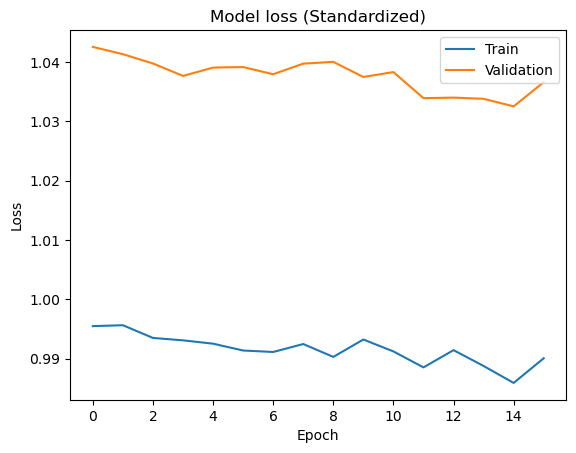

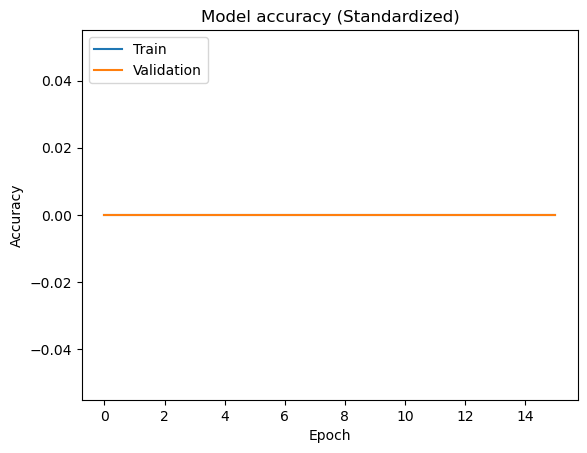

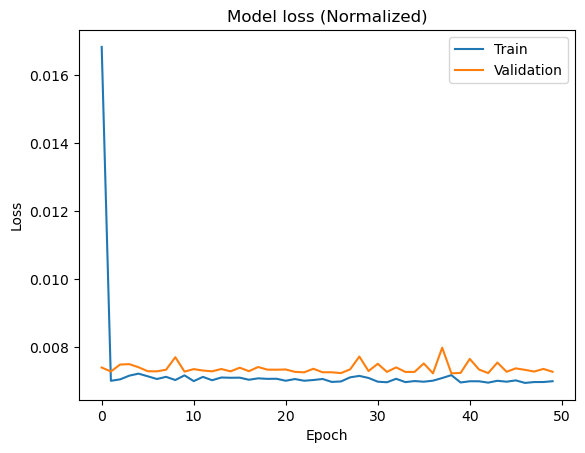

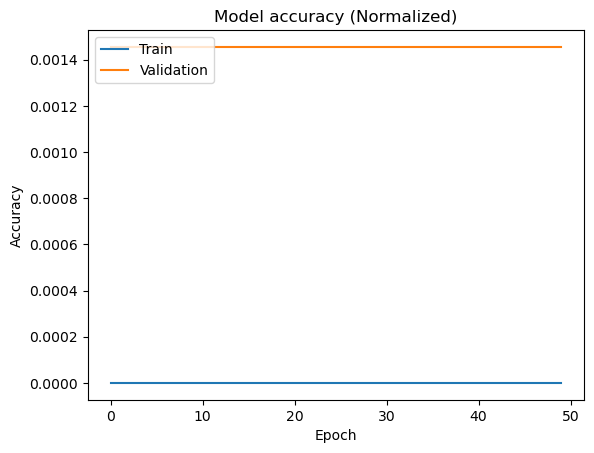

In [24]:
# Plot training & validation loss values for standardized data
plt.plot(history_std.history['loss'])
plt.plot(history_std.history['val_loss'])
plt.title('Model loss (Standardized)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_std.history['accuracy'])
plt.plot(history_std.history['val_accuracy'])
plt.title('Model accuracy (Standardized)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values for normalized data
plt.plot(history_norm.history['loss'])
plt.plot(history_norm.history['val_loss'])
plt.title('Model loss (Normalized)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_norm.history['accuracy'])
plt.plot(history_norm.history['val_accuracy'])
plt.title('Model accuracy (Normalized)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Candle_signal Evaluation

### Create a new column to capture up or down TREND. Defined as being above or below 200 SMA

In [25]:
candles0['Candle_signal'] = candles0.apply(lambda row: 0 if row.eq(0).all() else (1 if row.eq(1).sum() > row.eq(-1).sum() else -1), axis=1)


In [26]:
candles0['Candle_signal'].value_counts()

Candle_signal
 1    1688
-1    1202
 0     581
Name: count, dtype: int64

In [27]:
df0.reset_index(inplace = True)
candles0.reset_index(inplace = True)

In [28]:
df0['1dayreturn'] = df0['close'].pct_change(periods=1).shift(-1)
df0['2dayreturn'] = df0['close'].pct_change(periods=2).shift(-2)
df0['3dayreturn'] = df0['close'].pct_change(periods=3).shift(-3)
df0['4dayreturn'] = df0['close'].pct_change(periods=4).shift(-4)
df0['5dayreturn'] = df0['close'].pct_change(periods=5).shift(-5)
df0['6dayreturn'] = df0['close'].pct_change(periods=6).shift(-6)
df0['7dayreturn'] = df0['close'].pct_change(periods=7).shift(-7)
df0['8dayreturn'] = df0['close'].pct_change(periods=8).shift(-8)
df0['9dayreturn'] = df0['close'].pct_change(periods=9).shift(-9)
df0['10dayreturn'] = df0['close'].pct_change(periods=10).shift(-10)
df0['11dayreturn'] = df0['close'].pct_change(periods=11).shift(-11)


In [29]:
df_eval = pd.merge(df0, candles0, on='index')
sma_period = 150
df_eval['SMA150'] = df_eval['close'].rolling(window=sma_period).mean()
df_eval['downtrend_150'] = df_eval['close']<df_eval['SMA150']
df_eval['uptrend_150'] = df_eval['close']>df_eval['SMA150']

In [30]:
# Create columns to identify uptrend and downtrend
df_eval['downtrend'] = df_eval['close']<df_eval['SMA150']
df_eval['uptrend'] = df_eval['close']>df_eval['SMA150']


In [31]:
# Create a new dataframe for uptrend and downtrend
downtrend = df_eval[df_eval['downtrend']==True]
uptrend = df_eval[df_eval['uptrend']== True]

In [32]:
print(downtrend['Candle_signal'].value_counts())
print(uptrend['Candle_signal'].value_counts())

Candle_signal
 1    613
-1    487
 0    185
Name: count, dtype: int64
Candle_signal
 1    1008
-1     662
 0     367
Name: count, dtype: int64


In [33]:
sell_downtrend = downtrend[downtrend['Candle_signal'] == -1]
buy_downtrend = downtrend[downtrend['Candle_signal'] == 1]
hold_downtrend = downtrend[downtrend['Candle_signal'] == 0]

sell_uptrend = uptrend[uptrend['Candle_signal'] == -1]
buy_uptrend = uptrend[uptrend['Candle_signal'] == 1]
hold_uptrend = uptrend[uptrend['Candle_signal'] == 0]

In [34]:
print(sell_downtrend['Candle_signal'].value_counts())
print(buy_downtrend['Candle_signal'].value_counts())
print(hold_downtrend['Candle_signal'].value_counts())

print(sell_uptrend['Candle_signal'].value_counts())
print(buy_uptrend['Candle_signal'].value_counts())
print(hold_uptrend['Candle_signal'].value_counts())


Candle_signal
-1    487
Name: count, dtype: int64
Candle_signal
1    613
Name: count, dtype: int64
Candle_signal
0    185
Name: count, dtype: int64
Candle_signal
-1    662
Name: count, dtype: int64
Candle_signal
1    1008
Name: count, dtype: int64
Candle_signal
0    367
Name: count, dtype: int64


In [35]:
sell_downtrend

,index,Date,open,high,low,close,volume,rsi,sma,BBL_20_2.0,...,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_XSIDEGAP3METHODS,Candle_signal,SMA150,downtrend_150,uptrend_150,downtrend,uptrend
151,151,2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,49.736531,227.889069,205.700277,...,0.0,0.0,0.0,0.0,-1,325.335253,True,False,True,False
152,152,2015-02-16,234.824997,239.520996,229.022003,233.843002,28153700,49.357605,228.347135,209.738932,...,0.0,0.0,0.0,0.0,-1,324.262233,True,False,True,False
154,154,2015-02-18,243.779999,244.251007,232.339996,236.326004,25200800,50.140196,229.309735,209.128775,...,0.0,0.0,0.0,0.0,-1,322.076973,True,False,True,False
158,158,2015-02-22,244.544006,246.391998,233.850998,235.977005,19527000,49.361514,234.015670,210.551557,...,0.0,0.0,0.0,0.0,-1,317.355980,True,False,True,False
160,160,2015-02-24,238.998001,239.901001,236.401993,238.735001,14200400,50.682355,236.289336,211.554605,...,0.0,0.0,0.0,0.0,-1,315.180527,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303,3303,2023-10-03,27508.251953,27667.191406,27216.001953,27429.978516,11407814187,58.484943,26869.379167,25889.123602,...,0.0,0.0,0.0,0.0,-1,27864.373958,True,False,True,False
3305,3305,2023-10-05,27798.646484,28091.861328,27375.601562,27415.912109,11877253670,56.517654,26927.524609,25883.868524,...,0.0,0.0,0.0,0.0,-1,27858.147656,True,False,True,False
3309,3309,2023-10-09,27934.472656,27989.470703,27302.562500,27583.677734,12007668568,55.925229,27290.910417,25888.453353,...,0.0,0.0,0.0,0.0,-1,27873.800286,True,False,True,False
3310,3310,2023-10-10,27589.201172,27715.847656,27301.654297,27391.019531,9973350678,53.114576,27363.746354,25895.919979,...,0.0,0.0,0.0,0.0,-1,27877.846562,True,False,True,False


In [36]:
sell_downtrend.columns


Index(['index', 'Date', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'sma',
       'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ema', 'DMP_16',
       'DMN_16', '1dayreturn', '2dayreturn', '3dayreturn', '4dayreturn',
       '5dayreturn', '6dayreturn', '7dayreturn', '8dayreturn', '9dayreturn',
       '10dayreturn', '11dayreturn', 'CDL_3BLACKCROWS', 'CDL_3INSIDE',
       'CDL_3LINESTRIKE', 'CDL_3OUTSIDE', 'CDL_3WHITESOLDIERS',
       'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD', 'CDL_CLOSINGMARUBOZU',
       'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1', 'CDL_DOJISTAR',
       'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING', 'CDL_EVENINGDOJISTAR',
       'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE', 'CDL_GRAVESTONEDOJI',
       'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI', 'CDL_HARAMICROSS',
       'CDL_HIGHWAVE', 'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INSIDE',
       'CDL_INVERTEDHAMMER', 'CDL_LONGLEGGEDDOJI', 'CDL_LONGLI

# DOWNTREND

### SELL SIGNAL in a DOWNTREND

In [48]:
for column in sell_downtrend.columns[20:31]:  # Assuming your return columns start from the 5th column (index 4)
    positive_count = (sell_downtrend[column] > 0).sum()
    negative_count = (sell_downtrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()


# Create a DataFrame to store the results
sell_in_downtrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
for column in sell_downtrend.columns[20:31]:
    positive_count = (sell_downtrend[column] > 0).sum()
    negative_count = (sell_downtrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    sell_in_downtrend = pd.concat([sell_in_downtrend, new_row], ignore_index=True)

# Sort the DataFrame by Negative Count in descending order and Positive Count in ascending order
sell_in_downtrend = sell_in_downtrend.sort_values(by=['Negative Count', 'Positive Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results for Sell downtrend:")
print(sell_in_downtrend)


For column '1dayreturn':
  Positive count: 265
  Negative count: 222

For column '2dayreturn':
  Positive count: 255
  Negative count: 232

For column '3dayreturn':
  Positive count: 262
  Negative count: 225

For column '4dayreturn':
  Positive count: 260
  Negative count: 227

For column '5dayreturn':
  Positive count: 268
  Negative count: 219

For column '6dayreturn':
  Positive count: 275
  Negative count: 212

For column '7dayreturn':
  Positive count: 258
  Negative count: 228

For column '8dayreturn':
  Positive count: 264
  Negative count: 223

For column '9dayreturn':
  Positive count: 264
  Negative count: 223

For column '10dayreturn':
  Positive count: 265
  Negative count: 222

For column '11dayreturn':
  Positive count: 268
  Negative count: 219


Ranked Results for Sell downtrend:
         Column Positive Count Negative Count
1    2dayreturn            255            232
6    7dayreturn            258            228
3    4dayreturn            260            227
2    3da

### BUY SIGNAL in a DOWNTREND

In [49]:
for column in buy_downtrend.columns[20:31]:  # Assuming your return columns start from the 5th column (index 4)
    positive_count = (buy_downtrend[column] > 0).sum()
    negative_count = (buy_downtrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()

# Create a DataFrame to store the results
buy_in_downtrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
# Populate the DataFrame with results
for column in buy_downtrend.columns[20:31]:
    positive_count = (buy_downtrend[column] > 0).sum()
    negative_count = (buy_downtrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    buy_in_downtrend = pd.concat([buy_in_downtrend, new_row], ignore_index=True)

# Sort the DataFrame by Positive Count in descending order and Negative Count in ascending order
buy_in_downtrend = buy_in_downtrend.sort_values(by=['Positive Count', 'Negative Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results: BUY in downtrend")
print(buy_in_downtrend)

For column '1dayreturn':
  Positive count: 294
  Negative count: 319

For column '2dayreturn':
  Positive count: 313
  Negative count: 300

For column '3dayreturn':
  Positive count: 309
  Negative count: 304

For column '4dayreturn':
  Positive count: 313
  Negative count: 300

For column '5dayreturn':
  Positive count: 315
  Negative count: 298

For column '6dayreturn':
  Positive count: 304
  Negative count: 309

For column '7dayreturn':
  Positive count: 317
  Negative count: 296

For column '8dayreturn':
  Positive count: 316
  Negative count: 297

For column '9dayreturn':
  Positive count: 318
  Negative count: 295

For column '10dayreturn':
  Positive count: 317
  Negative count: 296

For column '11dayreturn':
  Positive count: 323
  Negative count: 290


Ranked Results: BUY in downtrend
         Column Positive Count Negative Count
10  11dayreturn            323            290
8    9dayreturn            318            295
6    7dayreturn            317            296
9   10dayr

In [39]:
hold_downtrend

,index,Date,open,high,low,close,volume,rsi,sma,BBL_20_2.0,...,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_XSIDEGAP3METHODS,Candle_signal,SMA150,downtrend_150,uptrend_150,downtrend,uptrend
156,156,2015-02-20,240.251007,247.100998,239.298996,243.779007,23876700,53.193284,231.982937,210.431413,...,0.0,0.0,0.0,0.0,0,319.717767,True,False,True,False
159,159,2015-02-23,235.994995,240.108994,232.421005,238.891998,16400000,50.763758,235.047669,210.998817,...,0.0,0.0,0.0,0.0,0,316.252427,True,False,True,False
165,165,2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,61.295773,242.199534,217.184952,...,0.0,0.0,0.0,0.0,0,310.806594,True,False,True,False
183,183,2015-03-19,255.880005,264.243988,248.636002,260.928009,52732000,45.326901,281.237069,253.613000,...,0.0,0.0,0.0,0.0,0,300.388500,True,False,True,False
208,208,2015-04-13,235.949997,236.934998,221.996002,224.587006,31181800,30.936419,246.091868,230.001425,...,0.0,0.0,0.0,0.0,0,282.296227,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,3281,2023-09-11,25831.714844,25883.947266,24930.296875,25162.654297,14600006467,33.007079,26072.227604,25018.901963,...,0.0,0.0,0.0,0.0,0,28176.210990,True,False,True,False
3302,3302,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,19793041322,60.003240,26824.332682,25844.141570,...,0.0,0.0,0.0,0.0,0,27874.204922,True,False,True,False
3311,3311,2023-10-11,27392.076172,27474.115234,26561.099609,26873.320312,13648094333,46.370587,27407.484375,25932.275193,...,0.0,0.0,0.0,0.0,0,27877.464440,True,False,True,False
3312,3312,2023-10-12,26873.292969,26921.439453,26558.320312,26756.798828,9392909295,44.986082,27434.423177,25955.412358,...,0.0,0.0,0.0,0.0,0,27874.558477,True,False,True,False


### HOLD SIGNAL in a DOWNTREND

In [50]:
for column in hold_downtrend.columns[20:31]:
    positive_count = (hold_downtrend[column] > 0).sum()
    negative_count = (hold_downtrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()

# Create a DataFrame to store the results
hold_in_downtrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
# Populate the DataFrame with results
for column in hold_downtrend.columns[20:31]:
    positive_count = (hold_downtrend[column] > 0).sum()
    negative_count = (hold_downtrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    hold_in_downtrend = pd.concat([hold_in_downtrend, new_row], ignore_index=True)

# Sort the DataFrame by Positive Count in descending order and Negative Count in ascending order
hold_in_downtrend = hold_in_downtrend.sort_values(by=['Positive Count', 'Negative Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results:HOLD in Downtrend")
print(hold_in_downtrend)

For column '1dayreturn':
  Positive count: 90
  Negative count: 95

For column '2dayreturn':
  Positive count: 92
  Negative count: 93

For column '3dayreturn':
  Positive count: 84
  Negative count: 101

For column '4dayreturn':
  Positive count: 91
  Negative count: 94

For column '5dayreturn':
  Positive count: 93
  Negative count: 92

For column '6dayreturn':
  Positive count: 93
  Negative count: 92

For column '7dayreturn':
  Positive count: 95
  Negative count: 90

For column '8dayreturn':
  Positive count: 92
  Negative count: 93

For column '9dayreturn':
  Positive count: 98
  Negative count: 87

For column '10dayreturn':
  Positive count: 97
  Negative count: 88

For column '11dayreturn':
  Positive count: 94
  Negative count: 91


Ranked Results:HOLD in Downtrend
         Column Positive Count Negative Count
8    9dayreturn             98             87
9   10dayreturn             97             88
6    7dayreturn             95             90
10  11dayreturn             94 

# UPTREND

### SELL SIGNAL in an UPTREND

In [51]:
for column in sell_uptrend.columns[20:31]:  # Assuming your return columns start from the 5th column (index 4)
    positive_count = (sell_uptrend[column] > 0).sum()
    negative_count = (sell_uptrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()


# Create a DataFrame to store the results
sell_in_uptrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
for column in sell_uptrend.columns[20:31]:
    positive_count = (sell_uptrend[column] > 0).sum()
    negative_count = (sell_uptrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    sell_in_uptrend = pd.concat([sell_in_uptrend, new_row], ignore_index=True)

# Sort the DataFrame by Negative Count in descending order and Positive Count in ascending order
sell_in_uptrend = sell_in_uptrend.sort_values(by=['Negative Count', 'Positive Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results for Sell Uptrend: SELL in UPTREND")
print(sell_in_uptrend)

For column '1dayreturn':
  Positive count: 387
  Negative count: 274

For column '2dayreturn':
  Positive count: 391
  Negative count: 270

For column '3dayreturn':
  Positive count: 392
  Negative count: 268

For column '4dayreturn':
  Positive count: 385
  Negative count: 275

For column '5dayreturn':
  Positive count: 390
  Negative count: 270

For column '6dayreturn':
  Positive count: 390
  Negative count: 270

For column '7dayreturn':
  Positive count: 396
  Negative count: 263

For column '8dayreturn':
  Positive count: 396
  Negative count: 263

For column '9dayreturn':
  Positive count: 397
  Negative count: 261

For column '10dayreturn':
  Positive count: 398
  Negative count: 260

For column '11dayreturn':
  Positive count: 403
  Negative count: 255


Ranked Results for Sell Uptrend: SELL in UPTREND
         Column Positive Count Negative Count
3    4dayreturn            385            275
0    1dayreturn            387            274
4    5dayreturn            390          

### BUY SIGNAL in an UPTREND

In [52]:
for column in buy_uptrend.columns[20:31]:  # Assuming your return columns start from the 5th column (index 4)
    positive_count = (buy_uptrend[column] > 0).sum()
    negative_count = (buy_uptrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()

# Create a DataFrame to store the results
buy_in_uptrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
# Populate the DataFrame with results
for column in buy_uptrend.columns[20:31]:
    positive_count = (buy_uptrend[column] > 0).sum()
    negative_count = (buy_uptrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    buy_in_uptrend = pd.concat([buy_in_uptrend, new_row], ignore_index=True)

# Sort the DataFrame by Positive Count in descending order and Negative Count in ascending order
buy_in_uptrend = buy_in_uptrend.sort_values(by=['Positive Count', 'Negative Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results: BUY in UPTREND")
print(buy_in_uptrend)

For column '1dayreturn':
  Positive count: 527
  Negative count: 480

For column '2dayreturn':
  Positive count: 547
  Negative count: 460

For column '3dayreturn':
  Positive count: 561
  Negative count: 446

For column '4dayreturn':
  Positive count: 564
  Negative count: 443

For column '5dayreturn':
  Positive count: 561
  Negative count: 446

For column '6dayreturn':
  Positive count: 563
  Negative count: 443

For column '7dayreturn':
  Positive count: 559
  Negative count: 447

For column '8dayreturn':
  Positive count: 566
  Negative count: 440

For column '9dayreturn':
  Positive count: 575
  Negative count: 431

For column '10dayreturn':
  Positive count: 597
  Negative count: 408

For column '11dayreturn':
  Positive count: 602
  Negative count: 403


Ranked Results: BUY in UPTREND
         Column Positive Count Negative Count
10  11dayreturn            602            403
9   10dayreturn            597            408
8    9dayreturn            575            431
7    8dayret

### HOLD SIGNAL in an UPTREND

In [53]:
for column in hold_uptrend.columns[20:31]:
    positive_count = (hold_uptrend[column] > 0).sum()
    negative_count = (hold_uptrend[column] < 0).sum()

    print(f"For column '{column}':")
    print(f"  Positive count: {positive_count}")
    print(f"  Negative count: {negative_count}")
    print()

# Create a DataFrame to store the results
hold_in_uptrend = pd.DataFrame(columns=['Column', 'Positive Count', 'Negative Count'])

# Populate the DataFrame with results
# Populate the DataFrame with results
for column in hold_uptrend.columns[20:31]:
    positive_count = (hold_uptrend[column] > 0).sum()
    negative_count = (hold_uptrend[column] < 0).sum()

    new_row = pd.DataFrame({
        'Column': [column],
        'Positive Count': [positive_count],
        'Negative Count': [negative_count]
    })

    hold_in_uptrend = pd.concat([hold_in_uptrend, new_row], ignore_index=True)

# Sort the DataFrame by Positive Count in descending order and Negative Count in ascending order
hold_in_uptrend = hold_in_uptrend.sort_values(by=['Positive Count', 'Negative Count'], ascending=[False, True])

# Display the ranked results
print("\nRanked Results: HOLD in UPTREND")
print(hold_in_uptrend)


For column '1dayreturn':
  Positive count: 208
  Negative count: 159

For column '2dayreturn':
  Positive count: 232
  Negative count: 135

For column '3dayreturn':
  Positive count: 223
  Negative count: 144

For column '4dayreturn':
  Positive count: 223
  Negative count: 143

For column '5dayreturn':
  Positive count: 225
  Negative count: 140

For column '6dayreturn':
  Positive count: 225
  Negative count: 140

For column '7dayreturn':
  Positive count: 224
  Negative count: 141

For column '8dayreturn':
  Positive count: 237
  Negative count: 127

For column '9dayreturn':
  Positive count: 233
  Negative count: 131

For column '10dayreturn':
  Positive count: 232
  Negative count: 132

For column '11dayreturn':
  Positive count: 229
  Negative count: 134


Ranked Results: HOLD in UPTREND
         Column Positive Count Negative Count
7    8dayreturn            237            127
8    9dayreturn            233            131
9   10dayreturn            232            132
1    2dayre